In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

In [23]:
BASE_DIR = "/Users/akshatha/GeorgakopoulosSoaresLab/g4_analysis"
SPECIES_DATA = f"{BASE_DIR}/results/species_data.csv"
G4_PATH = f"{BASE_DIR}/results/regex_g4_distribution.csv"
    
# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Eukaryota': '#8da0cb',
    'Archaea': '#e78ac3'
}

def get_domain(taxa):
    if taxa == 'viral':
        return 'Virus'
    elif taxa == 'bacteria':
        return 'Bacteria'
    elif taxa == 'archaea':
        return 'Archaea'
    else:
        return 'Eukaryota'

In [24]:
# read species data
df_species = pd.read_csv(f"{BASE_DIR}/results/species_data.csv")
df_species = df_species[["Accession", "Genome Size", "Taxa"]]
df_species = df_species.replace('na', np.nan)
df_species["Genome Size"] = df_species["Genome Size"].astype(float)
df_species["Domain"] = df_species["Taxa"].apply(get_domain)
df_species.head()

,Accession,Genome Size,Taxa,Domain
0,GCA_000002515.1,10689156.0,fungi,Eukaryota
1,GCA_031844645.1,6733472.0,bacteria,Bacteria
2,GCA_958295725.1,3665566.0,bacteria,Bacteria
3,GCA_000002765.3,23292622.0,protozoa,Eukaryota
4,GCA_000006645.1,4701745.0,bacteria,Bacteria


In [25]:
# read g4 data
df_g4 = pd.read_csv(G4_PATH)
df_g4 = df_g4[["accession", "g4_count"]]
df_g4 = df_g4.rename(columns={"accession": "Accession"})
df_g4["g4_count"] = df_g4["g4_count"].astype(float)
# merge with species data
df_g4 = pd.merge(df_g4, df_species, on="Accession")
df_g4["G4 Density (per Mb)"] = df_g4["g4_count"] / df_g4["Genome Size"] * 1000000
# log transform
df_g4["log10(Genome Size)"] = df_g4["Genome Size"].apply(lambda x: np.log10(x))
df_g4["log10(G4 count)"] = df_g4["g4_count"].apply(lambda x: np.log10(x+1))
df_g4["log10(G4 Density)"] = df_g4["G4 Density (per Mb)"].apply(lambda x: np.log10(x+1))
# create new column with genome size binned ( 0 means 0-0.99, 1 means 1-1.99 etc)
df_g4["log10(Genome Size) binned"] = df_g4["log10(Genome Size)"].apply(lambda x: int(x))
# filter out metagenomes and other taxa
df_g4 = df_g4[df_g4['Taxa'] != 'metagenomes']
df_g4 = df_g4[df_g4['Taxa'] != 'other']
df_g4.head()

,Accession,g4_count,Genome Size,Taxa,Domain,G4 Density (per Mb),log10(Genome Size),log10(G4 count),log10(G4 Density),log10(Genome Size) binned
0,GCA_000002515.1,36.0,10689156.0,fungi,Eukaryota,3.367899,7.028943,1.568202,0.640273,7
1,GCA_000002765.3,837.0,23292622.0,protozoa,Eukaryota,35.934125,7.367218,2.923244,1.567428,7
2,GCA_000002985.3,2372.0,100272607.0,invertebrate,Eukaryota,23.655513,8.001182,3.375298,1.391914,8
3,GCA_000006605.1,154.0,2476822.0,bacteria,Bacteria,62.176450,6.393895,2.190332,1.800555,6
4,GCA_000006645.1,66.0,4701745.0,bacteria,Bacteria,14.037341,6.672259,1.826075,1.177171,6


[ 0.52874504 -2.03874436]


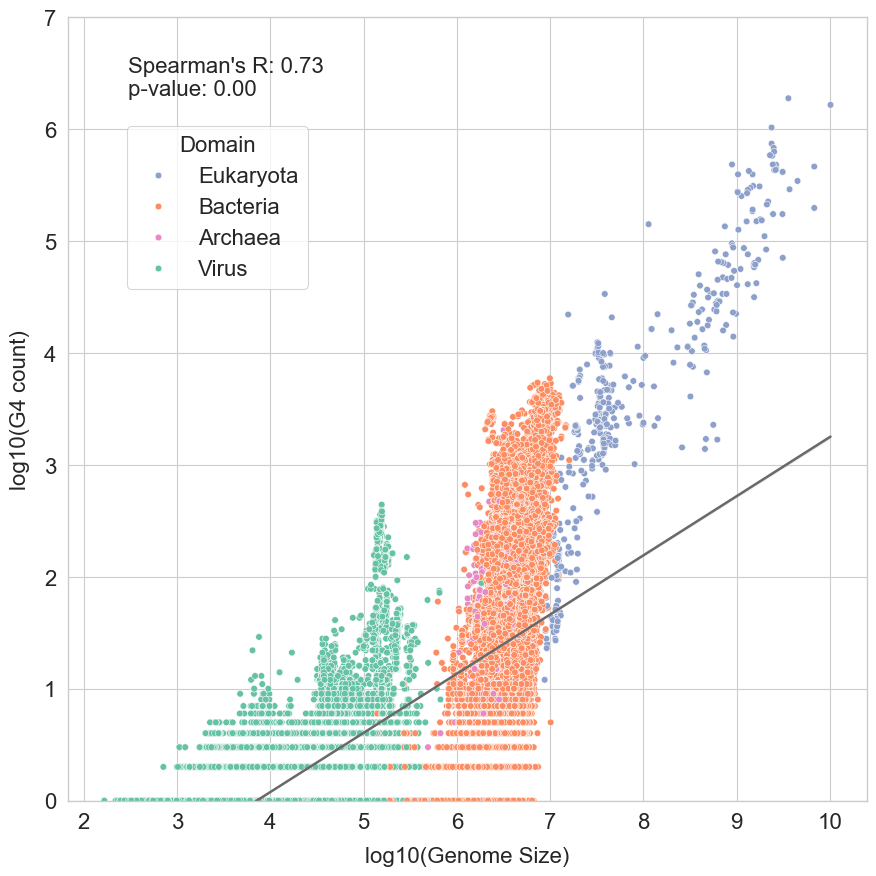

In [26]:
# plot the distribution of Genome size (log) vs G4 occurences (log10)
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(9, 9))
# set color map for domains
color_map = {
    'Virus': '#66c2a5',
    'Bacteria': '#fc8d62',
    'Eukaryota': '#8da0cb',
    'Archaea': '#e78ac3'
}
sns.scatterplot(
    data=df_g4,
    x="log10(Genome Size)",
    y="log10(G4 count)",
    hue="Domain",
    palette=color_map,
    ax=ax
)
sns.regplot(
    data=df_g4,
    x="log10(Genome Size)",
    y="log10(G4 count)",
    scatter=False,
    color='dimgrey',
    ax=ax
)

# set y axis limit
plt.ylim(0, 7)

# formatting
plt.xlabel("log10(Genome Size)", fontsize=16, labelpad=10)
plt.ylabel("log10(G4 count)", fontsize=16, labelpad=10)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.ticklabel_format(style='plain')
plt.legend(title="Domain", title_fontsize=16, fontsize=16, loc='upper left', bbox_to_anchor=(0.06, 0.875))
plt.tight_layout()

# display spearman correlation coefficient
corr, p = spearmanr(df_g4['log10(Genome Size)'], df_g4['log10(G4 count)'])
ax.text(0.075, 0.9, f"Spearman's R: {corr:.2f}\np-value: {p:.2f}", transform=ax.transAxes, fontsize=16)

plt.savefig(f"{BASE_DIR}/plots/genome_size_g4_count_regex.png")
# display slope and intercept
print(np.polyfit(df_g4['log10(Genome Size)'], df_g4['log10(G4 count)'], 1))

<Axes: xlabel='log10(Genome Size) binned', ylabel='log10(G4 count)'>

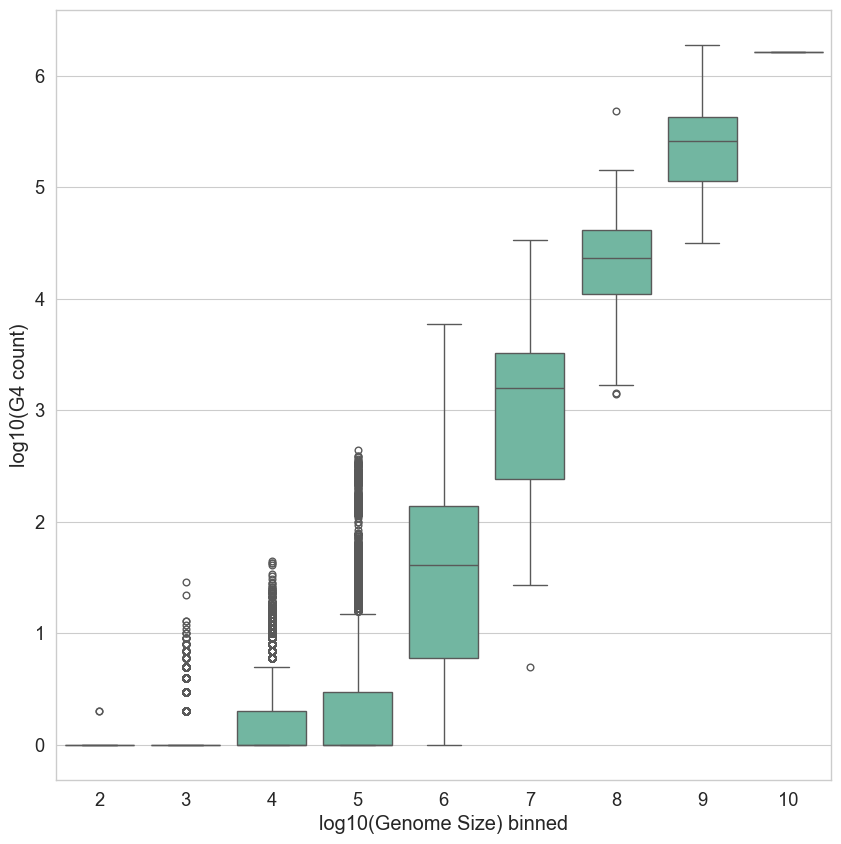

In [27]:
# box plot of Genome Size (log10) binned vs G4 occurrences (log10)
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
sns.boxplot(
    data=df_g4,
    x="log10(Genome Size) binned",
    y="log10(G4 count)",
    ax=ax
)
# plt.savefig(f"{BASE_DIR}/plots/genome_size_g4_count_boxplot_regex.png")

<Axes: xlabel='log10(Genome Size) binned', ylabel='log10(G4 count)'>

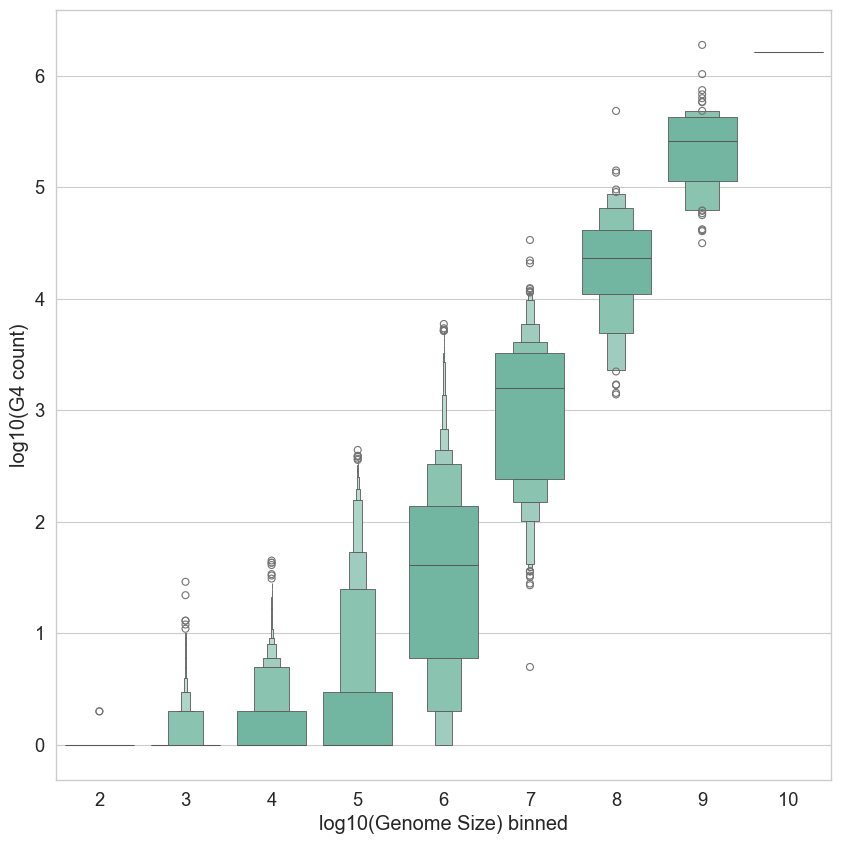

In [28]:
# boxen plot of Genome Size (log10) binned vs G4 occurrences (log10)
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
sns.boxenplot(
    data=df_g4,
    x="log10(Genome Size) binned",
    y="log10(G4 count)",
    ax=ax
)
# plt.savefig(f"{BASE_DIR}/plots/genome_size_g4_count_boxenplot_regex.png")

Virus correlation coefficient:  0.23912758611740767
Bacteria correlation coefficient:  0.6366346745669287
Archaea correlation coefficient:  0.5014758807126669
Eukaryota correlation coefficient:  0.8953601987597254


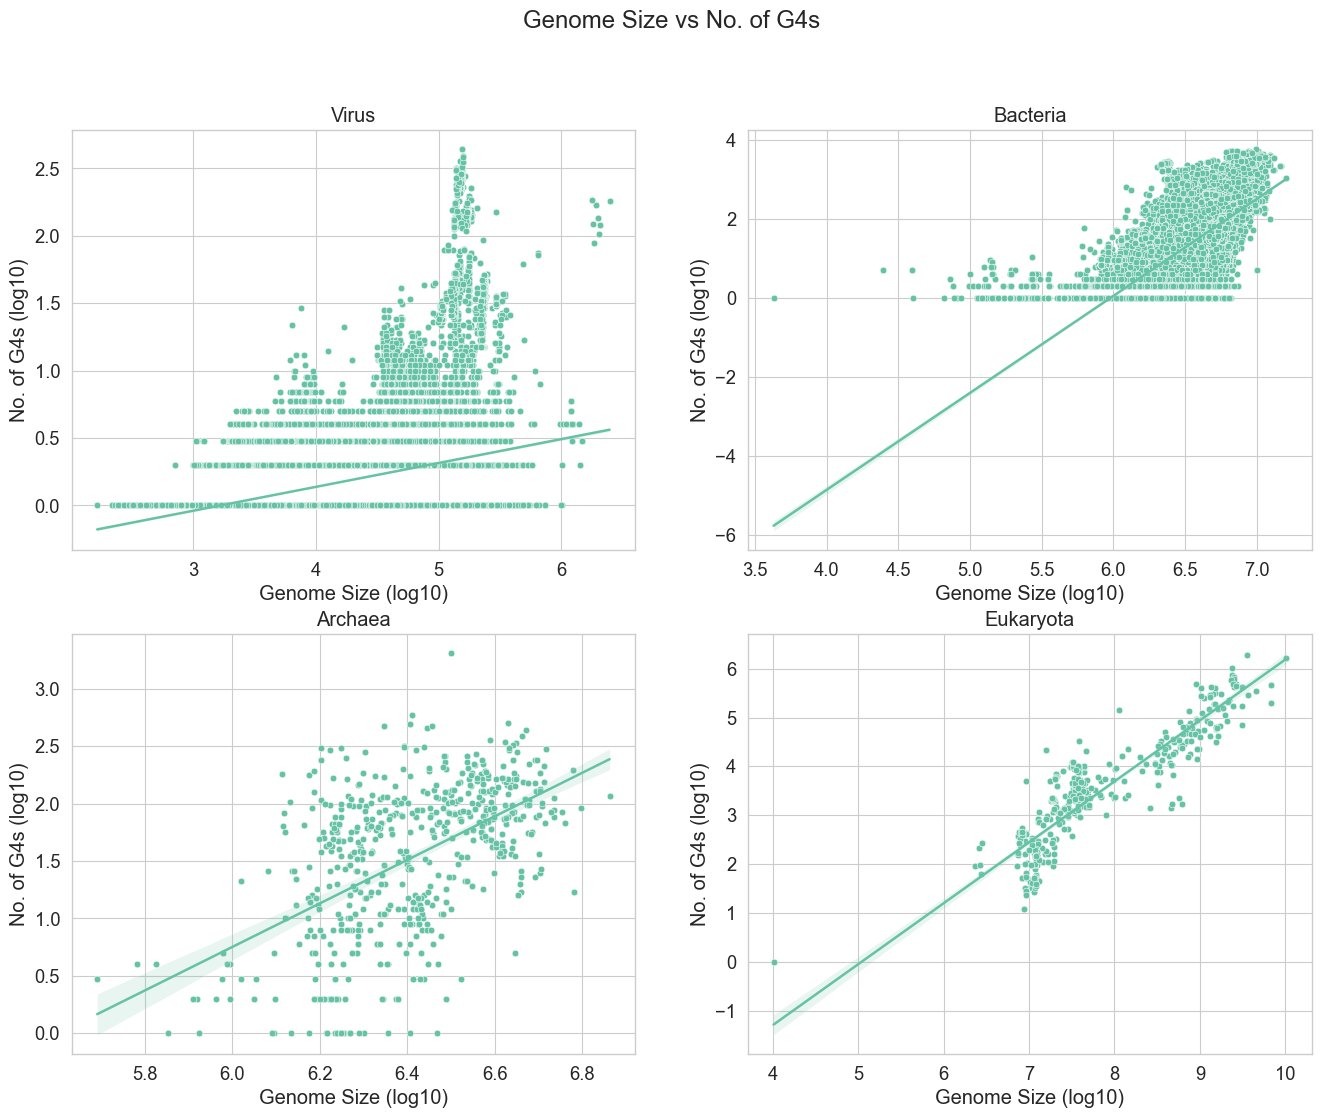

In [29]:
# plot the distribution of Genome size (log10) vs G4 occurences (log10) for each domain in a subplot
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Virus'],
    x="log10(Genome Size)",
    y="log10(G4 count)",
    ax=ax[0,0]
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Virus'],
    x="log10(Genome Size)",
    y="log10(G4 count)",
    ax=ax[0,0],
    scatter=False,
)
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Bacteria'],
    x="log10(Genome Size)",
    y="log10(G4 count)",
    ax=ax[0,1]
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Bacteria'],
    x="log10(Genome Size)",
    y="log10(G4 count)",
    ax=ax[0,1],
    scatter=False
)
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Archaea'],
    x="log10(Genome Size)",
    y="log10(G4 count)",
    ax=ax[1,0]
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Archaea'],
    x="log10(Genome Size)",
    y="log10(G4 count)",
    ax=ax[1,0],
    scatter=False
)
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Eukaryota'],
    x="log10(Genome Size)",
    y="log10(G4 count)",
    ax=ax[1,1]
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Eukaryota'],
    x="log10(Genome Size)",
    y="log10(G4 count)",
    ax=ax[1,1],
    scatter=False
)
# set title for each subplot
ax[0,0].set_title('Virus')
ax[0,1].set_title('Bacteria')
ax[1,0].set_title('Archaea')
ax[1,1].set_title('Eukaryota')

# set axis labels for each subplot
ax[0,0].set_xlabel('Genome Size (log10)')
ax[0,0].set_ylabel('No. of G4s (log10)')
ax[0,1].set_xlabel('Genome Size (log10)')
ax[0,1].set_ylabel('No. of G4s (log10)')
ax[1,0].set_xlabel('Genome Size (log10)')
ax[1,0].set_ylabel('No. of G4s (log10)')
ax[1,1].set_xlabel('Genome Size (log10)')
ax[1,1].set_ylabel('No. of G4s (log10)')

# set title for the entire plot
fig.suptitle("Genome Size vs No. of G4s")

# plt.savefig(f"{BASE_DIR}/plots/genome_size_g4_count_domain_regex.png")

# get correlation coefficient for each domain
virus_data = df_g4[df_g4['Domain'] == 'Virus']
bacteria_data = df_g4[df_g4['Domain'] == 'Bacteria']
archaea_data = df_g4[df_g4['Domain'] == 'Archaea']
eukaryota_data = df_g4[df_g4['Domain'] == 'Eukaryota']
print("Virus correlation coefficient: ", virus_data['Genome Size'].corr(virus_data['g4_count'], method='spearman'))
print("Bacteria correlation coefficient: ", bacteria_data['Genome Size'].corr(bacteria_data['g4_count'], method='spearman'))
print("Archaea correlation coefficient: ", archaea_data['Genome Size'].corr(archaea_data['g4_count'], method='spearman'))
print("Eukaryota correlation coefficient: ", eukaryota_data['Genome Size'].corr(eukaryota_data['g4_count'], method='spearman'))

<Axes: xlabel='log10(Genome Size)', ylabel='log10(G4 Density)'>

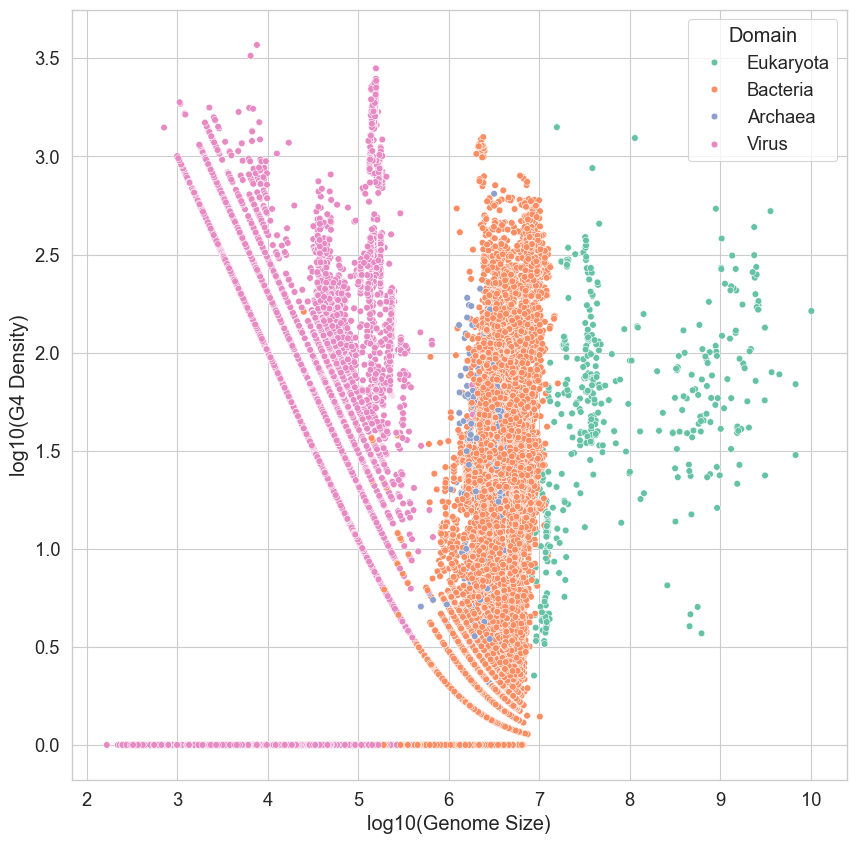

In [30]:
# plot the distribution of Genome Size vs G4 Density (per Mb)
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set_context("paper", font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(
    data=df_g4,
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    hue="Domain",
    ax=ax
)
# plt.savefig(f"{BASE_DIR}/plots/genome_size_g4_density_regex.png")

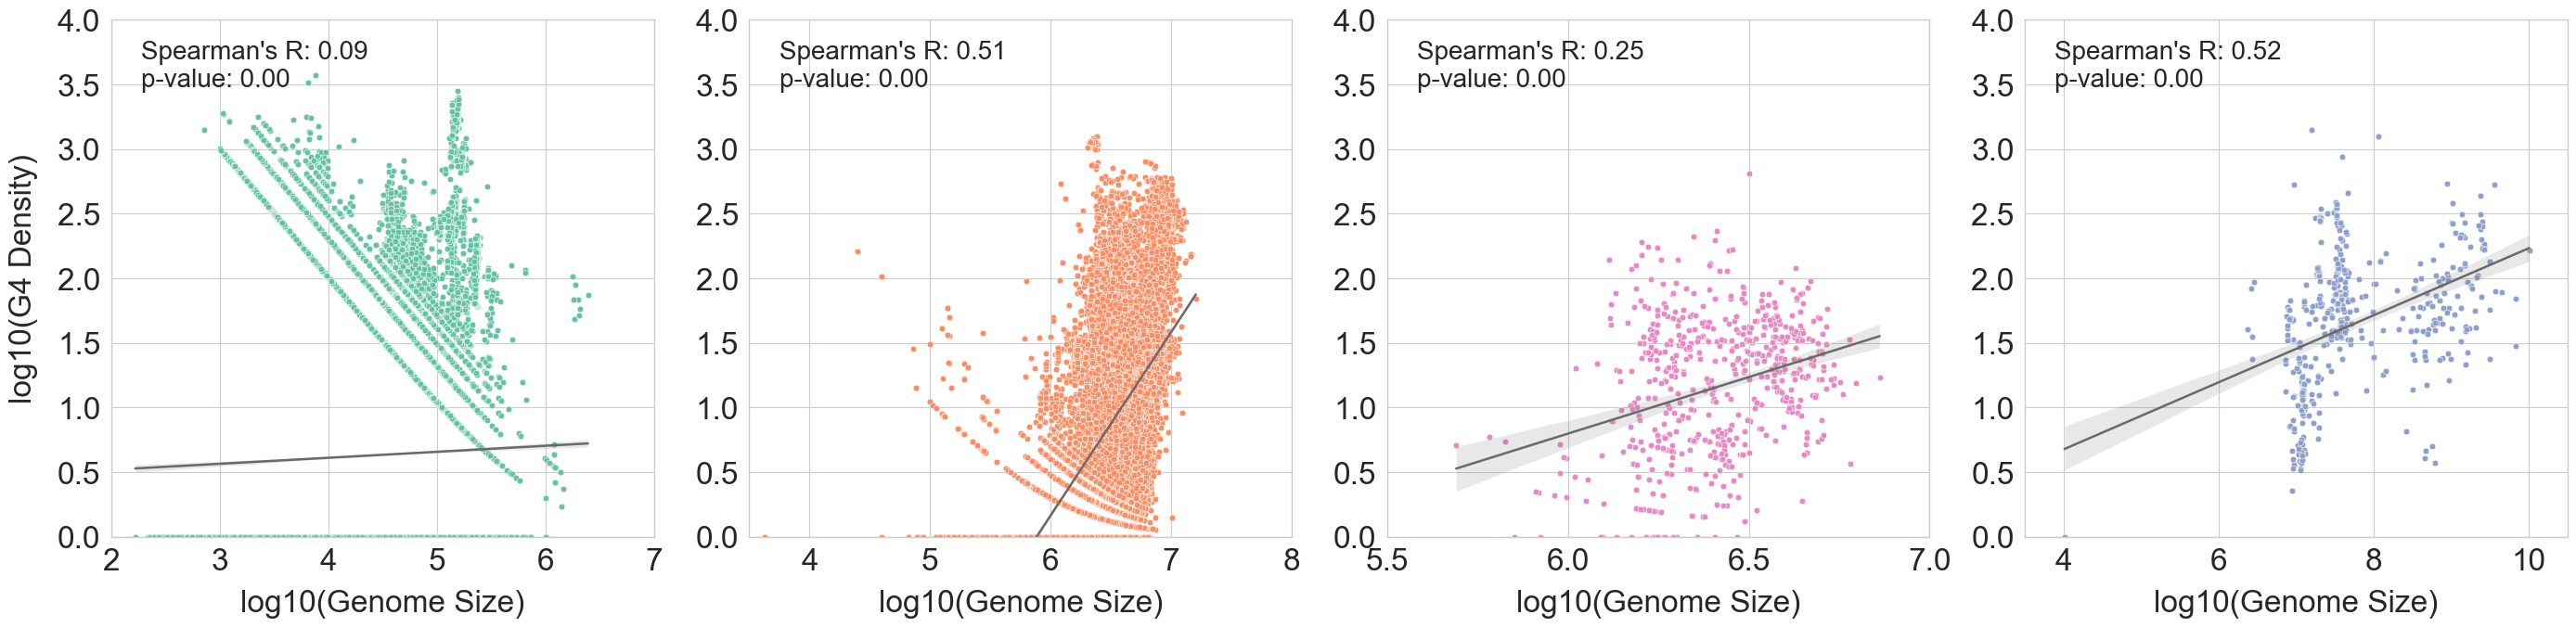

In [40]:
# plot the distribution of Genome size (log10) vs G4 Density (log10) for each domain in a subplot
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 4, figsize=(28, 7))
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Virus'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[0],
    color=color_map['Virus']
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Virus'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[0],
    scatter=False,
    color='dimgrey'
)
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Bacteria'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[1],
    color=color_map['Bacteria']
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Bacteria'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[1],
    scatter=False,
    color='dimgrey'
)
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Archaea'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[2],
    color=color_map['Archaea']
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Archaea'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[2],
    scatter=False,
    color='dimgrey'
)
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Eukaryota'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[3],
    color=color_map['Eukaryota']
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Eukaryota'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[3],
    scatter=False,
    color='dimgrey'
)

# set axis labels for each subplot
ax[0].set_xlabel('log10(Genome Size)', fontsize=24, labelpad=10)
ax[1].set_xlabel('log10(Genome Size)', fontsize=24, labelpad=10)
ax[2].set_xlabel('log10(Genome Size)', fontsize=24, labelpad=10)
ax[3].set_xlabel('log10(Genome Size)', fontsize=24, labelpad=10)

# set y label only for leftmost subplot
ax[0].set_ylabel('log10(G4 Density)', fontsize=24, labelpad=15)
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')

# specify x axis limits for each subplot
ax[0].set_xlim(2,7)
ax[1].set_xlim(3.5,8)
ax[2].set_xlim(5.5,7)
ax[3].set_xlim(3.5,10.5)

# specify y axis limits for each subplot
ax[0].set_ylim(0,4)
ax[1].set_ylim(0,4)
ax[2].set_ylim(0,4)
ax[3].set_ylim(0,4)

# set tick font size
ax[0].tick_params(axis='both', which='major', labelsize=24)
ax[1].tick_params(axis='both', which='major', labelsize=24)
ax[2].tick_params(axis='both', which='major', labelsize=24)
ax[3].tick_params(axis='both', which='major', labelsize=24)

# display correlation coefficient and p-values for each domain
virus_corr, virus_p = spearmanr(virus_data['log10(Genome Size)'], virus_data['log10(G4 Density)'])
bacteria_corr, bacteria_p = spearmanr(bacteria_data['log10(Genome Size)'], bacteria_data['log10(G4 Density)'])
archaea_corr, archaea_p = spearmanr(archaea_data['log10(Genome Size)'], archaea_data['log10(G4 Density)'])
eukaryota_corr, eukaryota_p = spearmanr(eukaryota_data['log10(Genome Size)'], eukaryota_data['log10(G4 Density)'])
ax[0].text(0.055, 0.87, f"Spearman's R: {virus_corr:.2f}\np-value: {virus_p:.2f}", transform=ax[0].transAxes, fontsize=20)
ax[1].text(0.055, 0.87, f"Spearman's R: {bacteria_corr:.2f}\np-value: {bacteria_p:.2f}", transform=ax[1].transAxes, fontsize=20)
ax[2].text(0.055, 0.87, f"Spearman's R: {archaea_corr:.2f}\np-value: {archaea_p:.2f}", transform=ax[2].transAxes, fontsize=20)
ax[3].text(0.055, 0.87, f"Spearman's R: {eukaryota_corr:.2f}\np-value: {eukaryota_p:.2f}", transform=ax[3].transAxes, fontsize=20)

plt.tight_layout()
plt.savefig(f"{BASE_DIR}/plots/genome_size_g4_density_domain_regex.png")

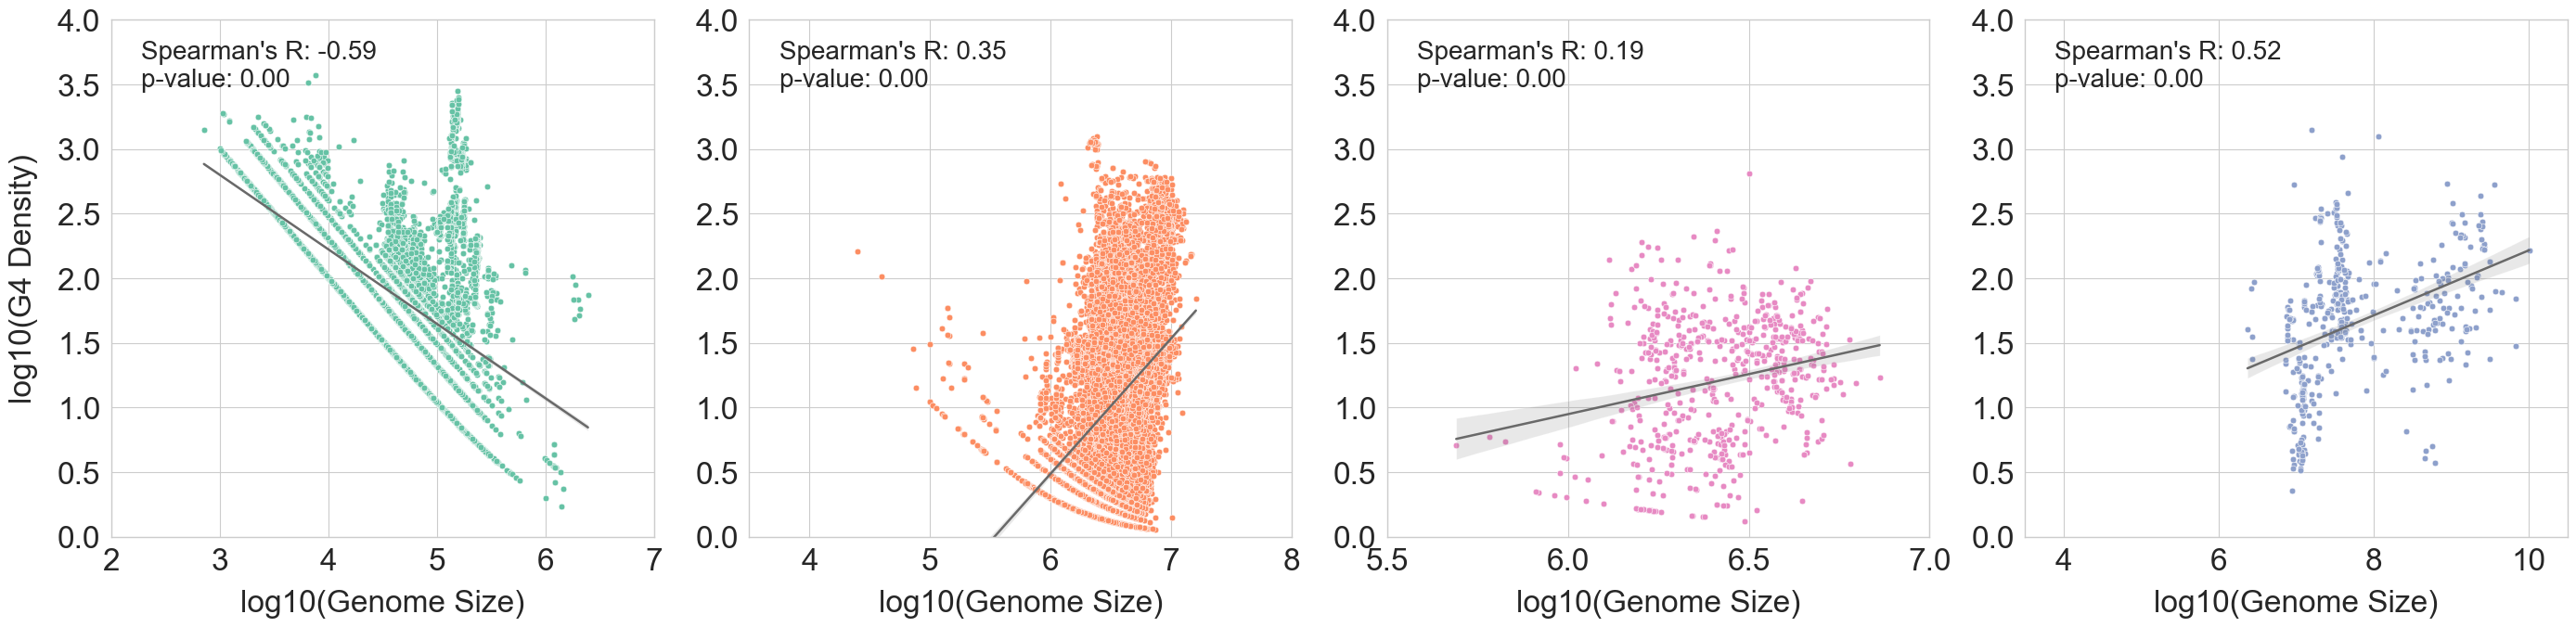

In [42]:
# plot the distribution of Genome size (log10) vs G4 Density (log10) for each domain in a subplot
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 4, figsize=(28, 7))
# filter out 0 values for G4 Density
df_g4 = df_g4[df_g4['G4 Density (per Mb)'] > 0]
virus_data = df_g4[df_g4['Domain'] == 'Virus']
bacteria_data = df_g4[df_g4['Domain'] == 'Bacteria']
archaea_data = df_g4[df_g4['Domain'] == 'Archaea']
eukaryota_data = df_g4[df_g4['Domain'] == 'Eukaryota']

sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Virus'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[0],
    color=color_map['Virus']
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Virus'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[0],
    scatter=False,
    color='dimgrey'
)
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Bacteria'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[1],
    color=color_map['Bacteria']
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Bacteria'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[1],
    scatter=False,
    color='dimgrey'
)
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Archaea'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[2],
    color=color_map['Archaea']
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Archaea'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[2],
    scatter=False,
    color='dimgrey'
)
sns.scatterplot(
    data=df_g4[df_g4['Domain'] == 'Eukaryota'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[3],
    color=color_map['Eukaryota']
)
sns.regplot(
    data=df_g4[df_g4['Domain'] == 'Eukaryota'],
    x="log10(Genome Size)",
    y="log10(G4 Density)",
    ax=ax[3],
    scatter=False,
    color='dimgrey'
)

# set axis labels for each subplot
ax[0].set_xlabel('log10(Genome Size)', fontsize=24, labelpad=10)
ax[1].set_xlabel('log10(Genome Size)', fontsize=24, labelpad=10)
ax[2].set_xlabel('log10(Genome Size)', fontsize=24, labelpad=10)
ax[3].set_xlabel('log10(Genome Size)', fontsize=24, labelpad=10)

# set y label only for leftmost subplot
ax[0].set_ylabel('log10(G4 Density)', fontsize=24, labelpad=15)
ax[1].set_ylabel('')
ax[2].set_ylabel('')
ax[3].set_ylabel('')

# specify x axis limits for each subplot
ax[0].set_xlim(2,7)
ax[1].set_xlim(3.5,8)
ax[2].set_xlim(5.5,7)
ax[3].set_xlim(3.5,10.5)

# specify y axis limits for each subplot
ax[0].set_ylim(0,4)
ax[1].set_ylim(0,4)
ax[2].set_ylim(0,4)
ax[3].set_ylim(0,4)

# set tick font size
ax[0].tick_params(axis='both', which='major', labelsize=24)
ax[1].tick_params(axis='both', which='major', labelsize=24)
ax[2].tick_params(axis='both', which='major', labelsize=24)
ax[3].tick_params(axis='both', which='major', labelsize=24)

# display correlation coefficient and p-values for each domain
virus_corr, virus_p = spearmanr(virus_data['log10(Genome Size)'], virus_data['log10(G4 Density)'])
bacteria_corr, bacteria_p = spearmanr(bacteria_data['log10(Genome Size)'], bacteria_data['log10(G4 Density)'])
archaea_corr, archaea_p = spearmanr(archaea_data['log10(Genome Size)'], archaea_data['log10(G4 Density)'])
eukaryota_corr, eukaryota_p = spearmanr(eukaryota_data['log10(Genome Size)'], eukaryota_data['log10(G4 Density)'])
ax[0].text(0.055, 0.87, f"Spearman's R: {virus_corr:.2f}\np-value: {virus_p:.2f}", transform=ax[0].transAxes, fontsize=20)
ax[1].text(0.055, 0.87, f"Spearman's R: {bacteria_corr:.2f}\np-value: {bacteria_p:.2f}", transform=ax[1].transAxes, fontsize=20)
ax[2].text(0.055, 0.87, f"Spearman's R: {archaea_corr:.2f}\np-value: {archaea_p:.2f}", transform=ax[2].transAxes, fontsize=20)
ax[3].text(0.055, 0.87, f"Spearman's R: {eukaryota_corr:.2f}\np-value: {eukaryota_p:.2f}", transform=ax[3].transAxes, fontsize=20)

plt.tight_layout()

